## Parameters

In [1]:
import os

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_PATH = os.path.abspath("F:/downloads_trash/mask_rcnn_bubbles_0010.h5")
DATASET_DIR= os.path.abspath("../MangaBubbles/")

print("Root:", ROOT_DIR)
print("Model:", MODEL_PATH)
print("Dataset:", DATASET_DIR)

Root: C:\Programming\Bubbles\Mask_RCNN
Model: F:\downloads_trash\mask_rcnn_bubbles_0010.h5
Dataset: C:\Programming\Bubbles\MangaBubbles


## Imports

In [2]:
import sys
import cv2
import numpy as np
import skimage
import copy
import random
import glob
import scipy

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils, visualize


import tensorflow
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)


import matplotlib.pyplot as plt

c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

## Helper Functions

In [3]:
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [38]:
def makeTransparent(mask, alpha=.6):
    src = mask
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, int(255*alpha), cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)
    return dst
    
def blend_transparent(face_img, overlay_t_img):
	# Split out the transparency mask from the colour info
	overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
	overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

	# Again calculate the inverse mask
	background_mask = 255 - overlay_mask

	# Turn the masks into three channel, so we can use them as weights
	overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
	background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

	# Create a masked out face image, and masked out overlay
	# We convert the images to floating point in range 0.0 - 1.0
	face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
	overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

	# And finally just add them together, and rescale it back to an 8bit integer image
	return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int32)
	for i in range(arrs.shape[2]):
		x[:,:]+= arrs[:,:,i]
	return x

# ==============================================================================



## Load Model and Image

In [5]:
class InferenceConfig(Config):
    BACKBONE= 'resnet50'
    
    IMAGE_RESIZE_MODE='crop'
    IMAGE_MIN_DIM=1728
    IMAGE_MAX_DIM=1728
    
    #TRAIN_ROIS_PER_IMAGE = 30
    
    #Blech
    NAME = "bubbles"
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_CHANNEL_COUNT= 1
    MEAN_PIXEL= np.array([123.7])

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir= ROOT_DIR)
model.load_weights(MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  1728
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1728
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1728 1728    1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

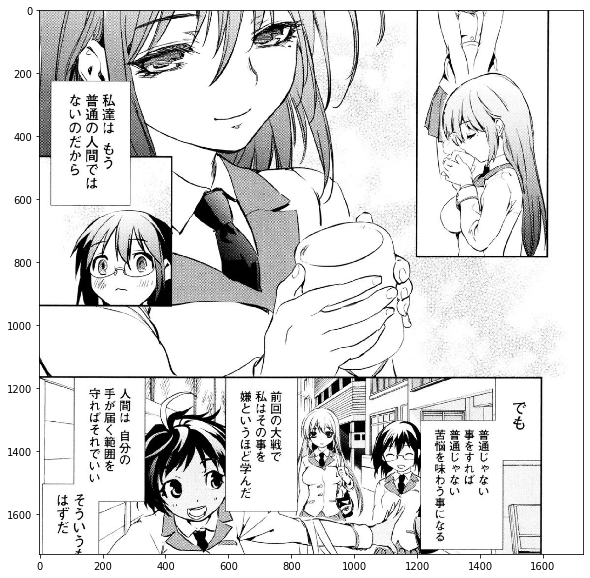

In [144]:
imPath= "C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/01_0018.jpg"
imPath= random.choice(glob.glob("C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/*"))

original_image= skimage.io.imread(imPath, as_gray=True)
if np.max(original_image) <= 1:
    original_image= original_image*255
if len(original_image.shape) == 2:
    original_image= original_image[..., np.newaxis]

original_image = utils.resize_image(original_image, min_dim=inference_config.IMAGE_MIN_DIM, max_dim=inference_config.IMAGE_MAX_DIM, min_scale=inference_config.IMAGE_MIN_SCALE, mode=inference_config.IMAGE_RESIZE_MODE)[0]
disp_image= np.concatenate((original_image, original_image, original_image),axis=2)

get_ax().imshow(disp_image.astype(np.uint8))

## Generate Mask

In [145]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (1728, 1728, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1728, 1728, 1)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1728.00000  int32
anchors                  shape: (1, 745767, 4)        min:   -0.20963  max:    1.17258  float32


[0.99951315 0.99725705 0.99426925 0.9927884 ]


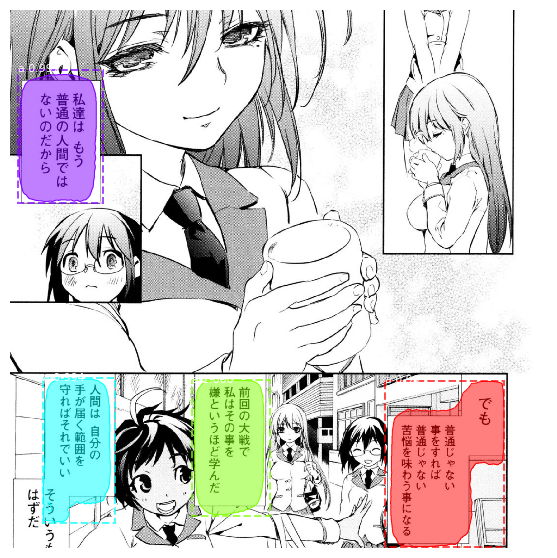

In [146]:
r = copy.deepcopy(results[0])
print(r['scores'])

inds= []
for i in reversed(range(len(r['scores']))):
    if r['scores'][i] > .98:
        break
    else:
        inds.append(i)

r['masks']= np.delete(r['masks'], inds, 2)
r['scores']= np.delete(r['scores'], inds, 0)
r['class_ids']= np.delete(r['class_ids'], inds, 0)
r['rois']= np.delete(r['rois'], inds, 0)

im= visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'], 
                            ['a']*123, r['scores'], ax=get_ax())

## Fill Bubbles

h
5275
[27  0  1  1  1]
h
31 45
(1728, 1728, 1)
(1728, 1728)
h
h


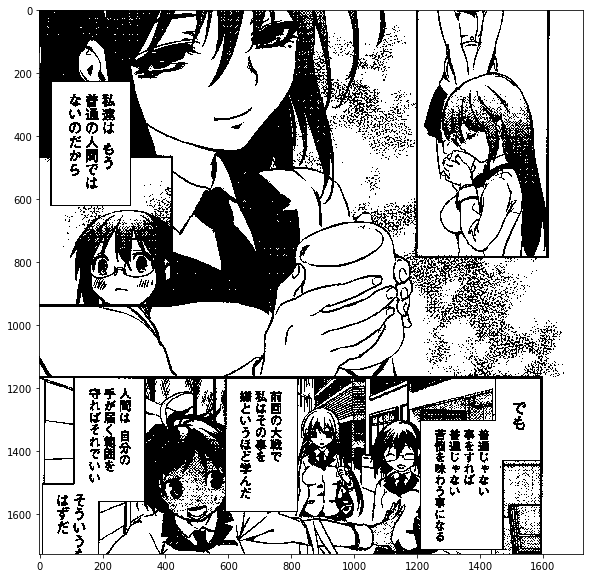

In [147]:
__, greyImage= cv2.threshold(original_image, 240, 1, cv2.THRESH_BINARY)

# generate blobs and move to separate array
output= cv2.connectedComponentsWithStats(greyImage, 8, cv2.CV_16U)
print('h')
print(len(output[2]))
print(output[2][2])
adds= [x for x in range(len(output[2])) if output[2][x][4] > 8000]
#cents= [x for x in range(len(output[2])) if x in adds]
print('h')
print(len(adds), len(cents))

arr= np.zeros(original_image.shape)
print(arr.shape)
out= output[1][...,np.newaxis]
print(output[1].shape)
c=0
for val in adds[1:]:
    arr= np.concatenate((arr, out == val), axis=2)
    c+=1
print('h')

greyImage= greyImage*255
get_ax().imshow(greyImage.astype(np.uint8), cmap='Greys_r')

print('h')
arr=arr*255

h
255.0
(1728, 1728, 31)
h
255.0


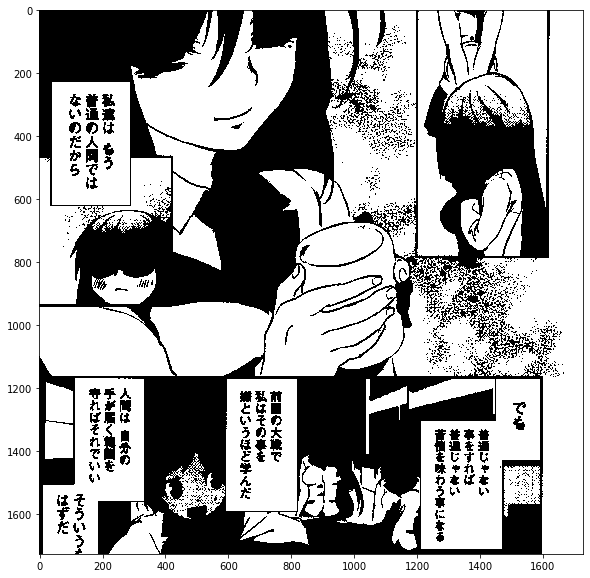

In [148]:

print('h')
print(np.max(arr))
print(arr.shape)
print('h')
arr2= flatten(arr.astype(np.uint8))
disp_image= np.dstack((arr2, arr2, arr2))
get_ax().imshow(disp_image.astype(np.uint8), cmap='Greys_r')
print(np.max(arr))

1728
(1728, 1728)
[ 707 1388]
(1728, 1728)
[162 428]
(1728, 1728)
[ 184 1447]
(1728, 1728)
[1394 1459]
{3904, 3893, 3924, 1573}


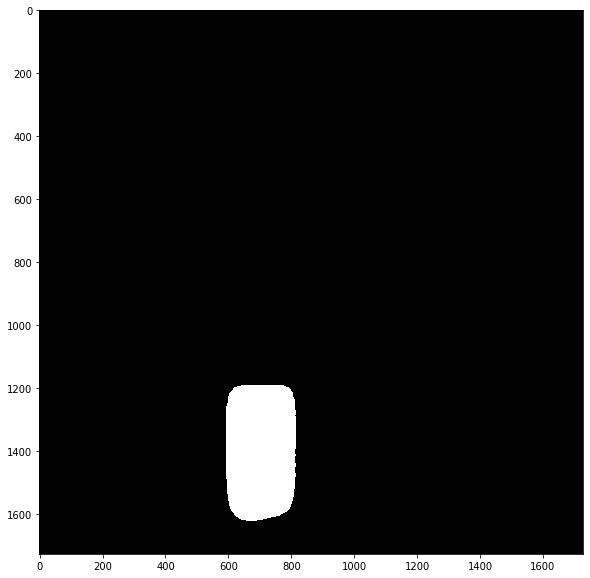

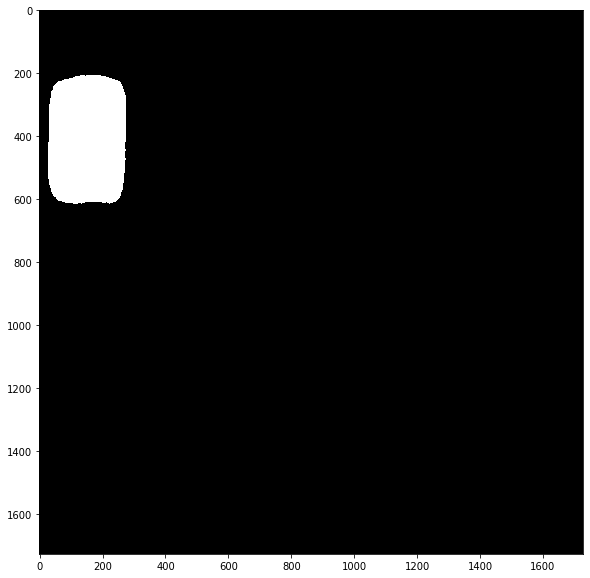

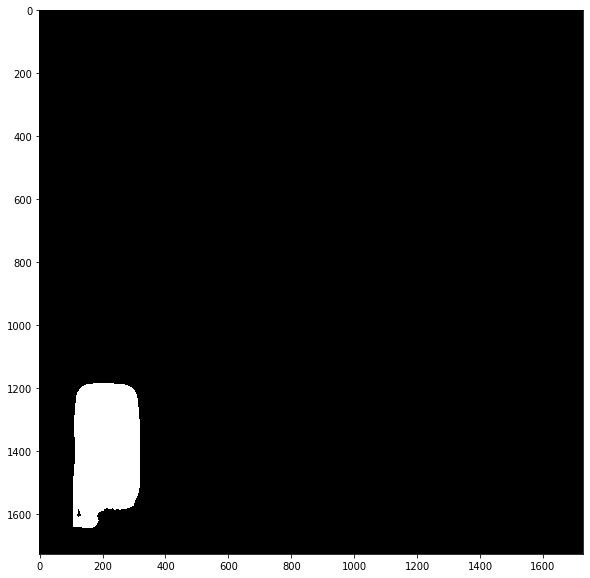

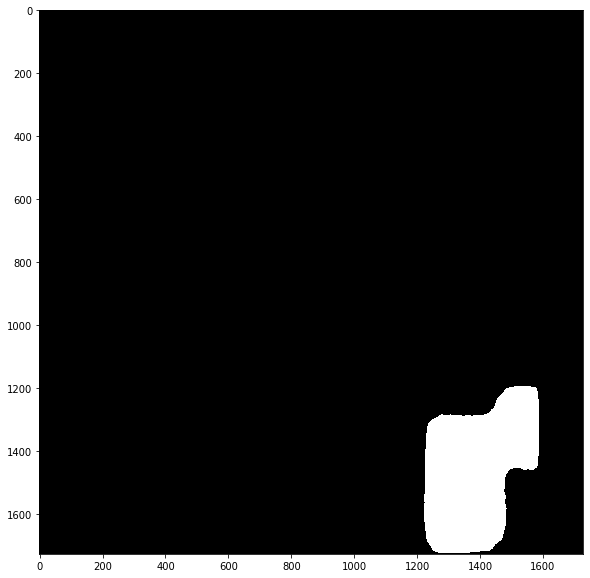

In [151]:
print(len(r['masks']))
#print(output[3])
okays= set([])
for msk in range(r['masks'].shape[2]):
    mask=r['masks'][:,:,msk]
    print(mask.shape)
    get_ax().imshow(mask.astype(np.uint8), cmap='Greys_r')
    for i in range(len(adds)):
        #print(output[3][adds[i]])
        coords= output[3][adds[i]]
        coords= coords.astype(np.uint16)
        #print(coords)
        if mask[coords[1]][coords[0]] and np.count_nonzero(np.logical_and(mask, output[1][:,:] == adds[i])) > 1000:
            print(coords)
            okays.add(adds[i])
print(okays)

(1728, 1728) [ 707.13715573 1388.89588445]
255
(1728, 1728) [ 184.80764362 1447.23603003]
255
(1728, 1728) [1394.02856093 1459.90292292]
255
(1728, 1728) [162.49673725 428.93893552]
255


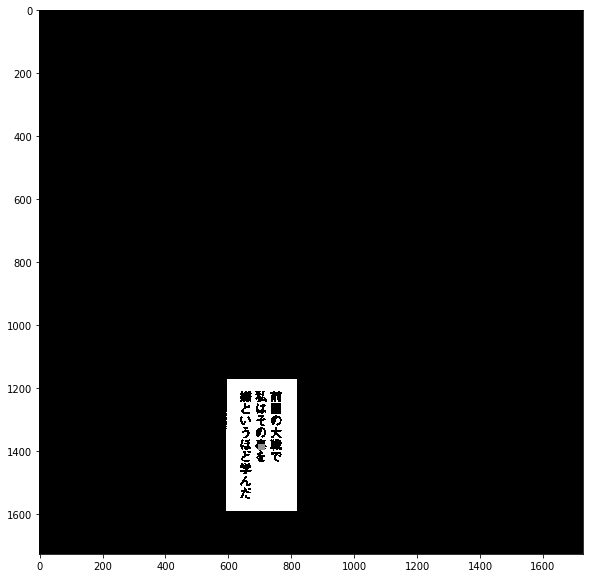

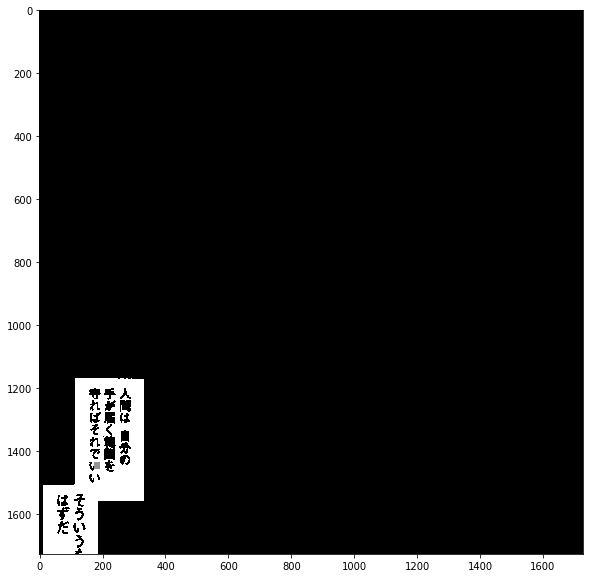

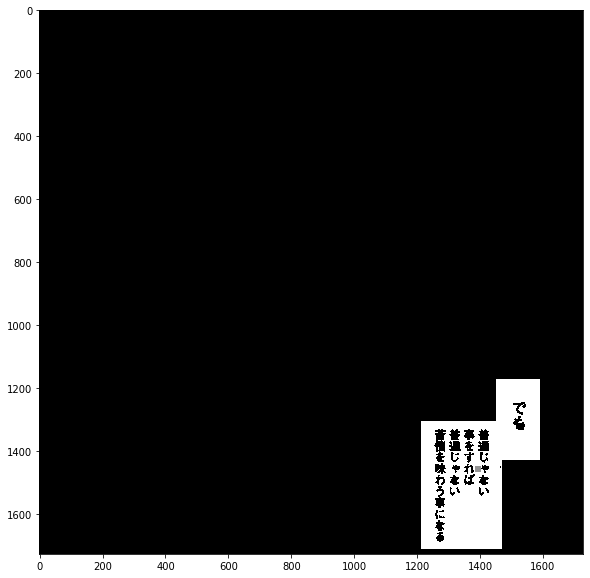

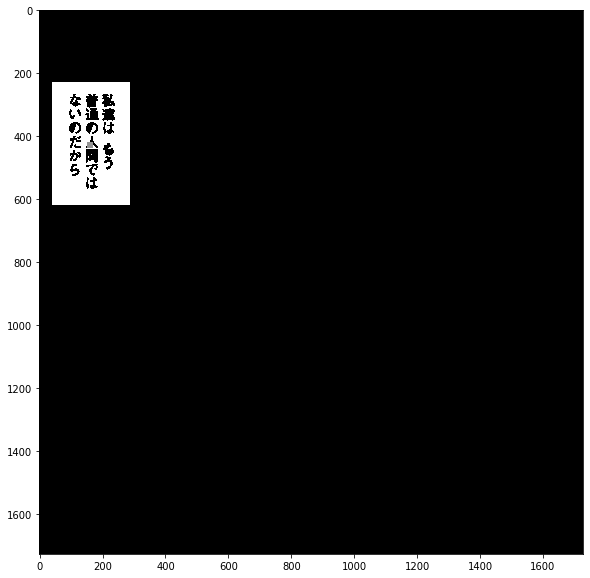

In [152]:
for b in okays:
#b=3924
    test= output[1][:,:] == b
    print(test.shape, output[3][b])
    test=test*255
    test[40,50] = 127
    coords= output[3][b].astype(np.uint16)
    test[coords[1]-10:coords[1]+10, coords[0]-10:coords[0]+10] = 126
    print(np.max(test))
    get_ax().imshow(test.astype(np.uint8), cmap='Greys_r')

(1728, 1728, 1)


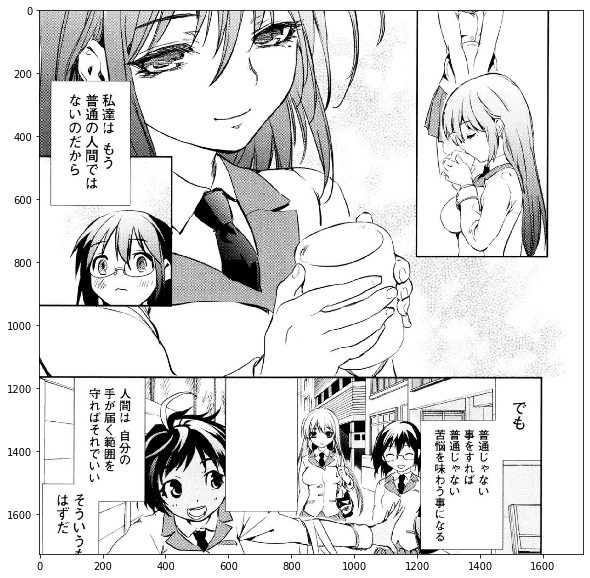

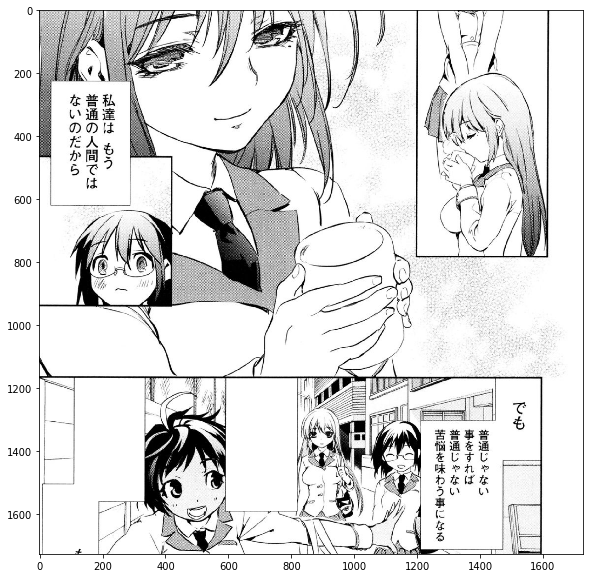

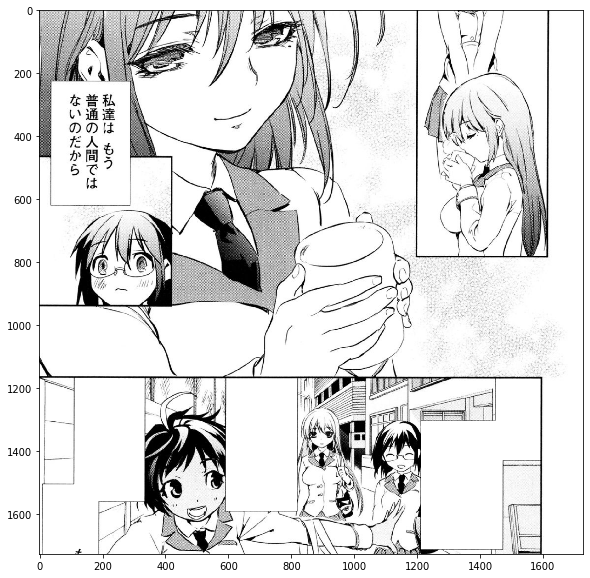

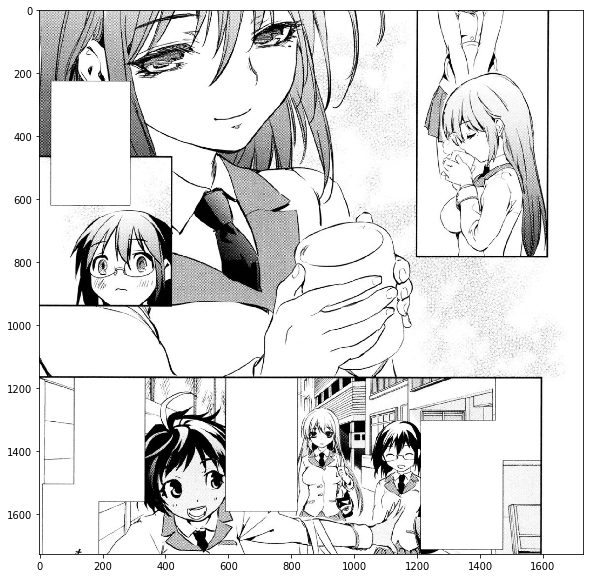

In [172]:
import png

show= original_image
print(show.shape)

for b in okays:
    test= output[1][:,:] == b
    test=test*255
    
    fill = scipy.ndimage.binary_fill_holes(test).astype(np.uint8)*255
    
    show= np.maximum(fill[:,:,np.newaxis], show)
    disp= np.concatenate((show,show,show),axis=2)
    get_ax().imshow(disp.astype(np.uint8), cmap='Greys_r')
png.from_array(np.uint8(show), mode="L").save(f"C:/Users/Pray/Pictures/test3.png")